In [1]:
import numpy as np
import pickle as pkl
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn   
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def load_data(path):
    with open(path, 'rb') as f:
        data = pkl.load(f)
    return data

# Load the data
Interaction_matrices = load_data('/Users/sanazkazeminia/Documents/Mass_Spec_project/Mass_Spec_ML_Project/binary_interaction_matrices_10binned.pkl')
spectral_data = load_data('/Users/sanazkazeminia/Documents/Mass_Spec_project/Mass_Spec_ML_Project/binary_spectra_dataset_10binned.pkl')

print(Interaction_matrices.shape)
print(spectral_data.shape)

cpu
torch.Size([100000, 6, 6])
torch.Size([100000, 2001])


In [2]:
import random

# Set a random seed for reproducibility 
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

autoencoder = torch.load('autoencoder.pth')

In [6]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, neurons, latent_size, input): # neurons is a list of the number of neurons in each layer
        super(Autoencoder, self).__init__()

        # Encoder
        encoder_layers = []
        input_size = input
        for n in neurons:
            encoder_layers.append(nn.Linear(input_size, n))
            encoder_layers.append(nn.ReLU())
            input_size = n
        encoder_layers.append(nn.Linear(input_size, latent_size))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = []
        input_size = latent_size
        for n in reversed(neurons):
            decoder_layers.append(nn.Linear(input_size, n))
            decoder_layers.append(nn.ReLU())
            input_size = n
        decoder_layers.append(nn.Linear(input_size, input))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [8]:
neurons = 512, 256, 128
latent_size = 64
input = 2001

state_dict = torch.load('autoencoder.pth')
model = Autoencoder(neurons, latent_size, input)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
encoded_spectra = model.encoder(spectral_data)
print(encoded_spectra.shape)
print(encoded_spectra.type())

torch.Size([100000, 64])
torch.FloatTensor


In [13]:
decoded_spectra = model.decoder(encoded_spectra)
print(decoded_spectra.shape)
print(decoded_spectra.type())

torch.Size([100000, 2001])
torch.FloatTensor


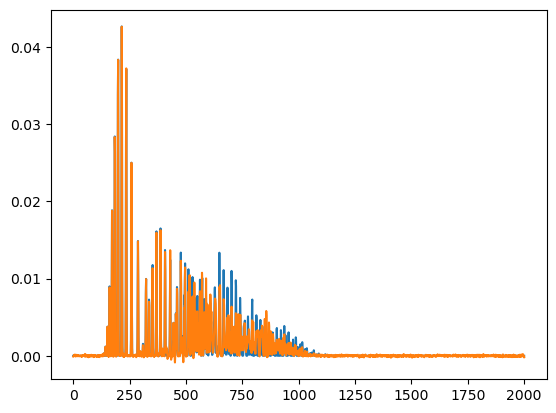

In [15]:
import matplotlib.pyplot as plt


In [16]:
for matrix in Interaction_matrices: # forgot to zero out the diagonal
    matrix[0,0] = 0

In [21]:
# flattening and stacking interaction matrices
flattened_matrices = [matrix.flatten() for matrix in Interaction_matrices] # storing in an array
flattened_matrices = torch.stack(flattened_matrices) # stacking the array
print(flattened_matrices.shape)
print(flattened_matrices[0]) # example to see the shape


torch.Size([100000, 36])
tensor([0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.])


In [25]:
X_train, X_test, y_train, y_test = train_test_split(encoded_spectra, flattened_matrices, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)



torch.Size([80000, 64])
torch.Size([10000, 64])
torch.Size([10000, 64])
torch.Size([80000, 36])
torch.Size([10000, 36])
torch.Size([10000, 36])


In [30]:
import torch 
from torch.utils.data import DataLoader, TensorDataset


batch_size = 264 ## 512 is a good number for now. ?? 256 also worked well.
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [59]:
import torch.nn as nn

class SpectralNet(nn.Module):
    def __init__(self):
        super(SpectralNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(64, 128 ), # 2001 is the number of features in the spectra data
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),  # Added layer
            nn.ReLU(),  # Added activation function
            nn.Linear(128, 36), # 36 is the number of features in the flattened interaction matrix (multilabel classification)
            nn.Sigmoid() # sigmoid activation function for multilabel classification 
        )
    def forward(self, x):
        return self.model(x)
    


In [60]:
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR

model = SpectralNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001) # lr = 0.001 works well
scheduler = CyclicLR(optimizer, base_lr=1e-7, max_lr=1e-4, step_size_up=2000, mode='triangular')

#criterion = AsymmetricLossMultiLabel(gamma_neg=4, gamma_pos=0, clip=1.0) 
criterion = nn.BCELoss() # binary cross entropy loss for multilabel classification


In [61]:
# function to calculate the gradient norms
def compute_gradient_norms(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    return total_norm

In [62]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import wandb
from sklearn.metrics import f1_score, hamming_loss, precision_score, recall_score, jaccard_score

def train(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs, threshold):
    train_epoch_losses = []
    val_epoch_losses = []


    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        train_loss = 0.0

        
        for batch in train_loader:
            X, y = batch
            X = X.detach().to(device)
            y = y.detach().to(device)

            optimizer.zero_grad()

            
            # Forward pass
            y_pred = model(X)
            loss = criterion(y_pred, y)
            
            # Accumulate batch loss
            train_loss += loss.item()
            
            # Backprop and optimize
            loss.backward()

            # Gradient clipping
            gradient_norm = compute_gradient_norms(model)
            optimizer.step()
        
            scheduler.step()

        # Average loss for the epoch
        train_loss /= len(train_loader)
        train_epoch_losses.append(train_loss)
                

        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")        


        # Set model to evaluation mode

        model.eval()
        val_loss = 0.0
        y_true_list = []
        y_pred_list = []  

        with torch.no_grad():
            for batch in val_loader:
                X, y = batch
                
                # Forward pass
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()

                binary_predictions = (outputs > threshold).float()
                
                y_pred_list.append(binary_predictions.cpu().numpy())
                y_true_list.append(y.cpu().numpy())
            

            val_loss /= len(val_loader)
            val_epoch_losses.append(val_loss)


        y_true = np.concatenate(y_true_list, axis=0)
        y_pred = np.concatenate(y_pred_list, axis=0)

        y_true = y_true.astype(int)
        y_pred = y_pred.astype(int)

        hamming_loss_value = hamming_loss(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='micro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
        jaccard_score_value = jaccard_score(y_true, y_pred, average='micro')

                    
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f},jacquard_loss:{jaccard_score_value}, hammingloss: {hamming_loss_value:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        wandb.log({
            "Train Loss": train_loss,
            "Val Loss": val_loss,
            "Hamming Loss": hamming_loss_value,
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Jaccard Score": jaccard_score_value,
            "gradient_norm": gradient_norm
        })
        if (epoch + 1) % 10 == 0:
                state = {
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'loss': train_loss,
                }
                torch.save(state, "binary_model.pth") ## save the model every x epochs
                print("Saved model to:", "binary_model.pth")
    



    wandb.finish()
    return train_epoch_losses, val_epoch_losses, y_true , y_pred 

In [63]:
import wandb

wandb.init(
    # set the wandb project where this run will be logged
    project="AutoEncoder_SpectralNet_Binary_10binned",
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "ANN",
    "dataset": "binary_10binned",
    "epochs": 100,
    "batch_size": 256,
    "optimizer": "Adam",
    "loss_function": "BCELoss",
    "scheduler": "CyclicLR",
    "max_lr": 1e-2,
    "base_lr": 1e-4,
    })

train_epoch_losses, val_epoch_losses, y_true_list, y_pred_list = train(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=100, threshold=0.5)

Epoch [1/100], Train Loss: 0.6923
Epoch [1/100], Val Loss: 0.6911,jacquard_loss:0.29960397543129114, hammingloss: 0.4868, Precision: 0.4998, Recall: 0.4279, F1: 0.4611
Epoch [2/100], Train Loss: 0.6832
Epoch [2/100], Val Loss: 0.6744,jacquard_loss:0.3528765074735151, hammingloss: 0.4856, Precision: 0.5010, Recall: 0.5441, F1: 0.5217
Epoch [3/100], Train Loss: 0.6741
Epoch [3/100], Val Loss: 0.6740,jacquard_loss:0.35177981189551727, hammingloss: 0.4865, Precision: 0.5002, Recall: 0.5424, F1: 0.5205
Epoch [4/100], Train Loss: 0.6740
Epoch [4/100], Val Loss: 0.6740,jacquard_loss:0.35164042116171057, hammingloss: 0.4866, Precision: 0.5000, Recall: 0.5423, F1: 0.5203
Epoch [5/100], Train Loss: 0.6740
Epoch [5/100], Val Loss: 0.6741,jacquard_loss:0.32718073715816953, hammingloss: 0.4861, Precision: 0.5006, Recall: 0.4857, F1: 0.4930
Epoch [6/100], Train Loss: 0.6740
Epoch [6/100], Val Loss: 0.6741,jacquard_loss:0.3130143356657078, hammingloss: 0.4863, Precision: 0.5005, Recall: 0.4552, F1: 0

F1,▁▇▃▄▄▆▄▄▂▅▇█▄▆█▇▇▇▆▇▆▇██▇▆▆▇▆▇▆▇▇▆▇▇▇█▇▇
Hamming Loss,▅▄▃▃▃▅▄▃▂▄▄▄▄▄▆▄█▅▅▅▅▅▅▅▅▄▂▆▄▄▃▃▃▃▂▁▂▃▂▂
Jaccard Score,▁▇▃▄▄▆▄▄▂▄▇█▄▆█▇▇▇▆▇▆▇█▇▇▆▆▇▆▇▆▇▇▆▇▇▇█▇▇
Precision,▄▅▆▆▆▄▅▆▇▆▅▅▅▅▃▅▁▄▄▄▄▄▄▄▄▅▇▃▅▅▆▇▆▆▇█▇▆▇▇
Recall,▁▇▂▄▄▆▄▄▂▄▇█▄▅█▇▇▇▆▇▆▆█▇▇▆▆▇▆▇▆▆▇▆▇▇▇█▇▇
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gradient_norm,▁██▇███▇▅▅▅▅▄▄▃▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
F1,0.5246
Hamming Loss,0.48574
Jaccard Score,0.35557


In [64]:
print(y_true_list.shape)
print(y_pred_list.shape)

print(y_true_list[0])
print(y_pred_list[0])

(10000, 36)
(10000, 36)
[0 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 0]
[0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0]


In [65]:
def evaluate(model,loader, criterion):
    model.eval()
    val_loss = 0.0
    y_true = []
    y_pred = []
    

    with torch.no_grad():
        for batch in loader:
            X, y = batch
            
            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            y_pred.extend(outputs.cpu().numpy())
            y_true.extend(y.cpu().numpy())
            val_loss /= len(loader)
    
    print(f"Loss: {val_loss:.4f}")

    return y_true, y_pred

y_true, y_pred = evaluate(model, train_loader, criterion)





Loss: 0.0022


In [66]:
print(y_true[2])
print(y_pred[2])

print((y_true[2]))

[0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0.]
[2.3122513e-05 4.9266773e-01 4.9645618e-01 5.0330520e-01 5.0295907e-01
 5.0152701e-01 4.9854192e-01 5.0247651e-01 4.9489063e-01 5.0807989e-01
 5.0239098e-01 5.1022941e-01 4.9325010e-01 5.0291073e-01 4.9098292e-01
 4.9441391e-01 4.9656031e-01 4.9320272e-01 4.9932137e-01 5.0187761e-01
 5.0121766e-01 4.9783710e-01 5.0512588e-01 4.9686161e-01 4.9527276e-01
 4.9696052e-01 5.0275314e-01 5.0624770e-01 4.9570268e-01 5.0011384e-01
 5.0269604e-01 5.0046551e-01 5.0117725e-01 4.9100143e-01 4.9886787e-01
 4.9155200e-01]
